In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from numba.decorators import jit
import random
from random import randint
import itertools
from queue import deque

In [2]:
def get_undirected_edges(g):
    return tuple(sorted(tuple(sorted(e)) for e in g.edges))

def has_cycles(g):
    try:
        c = nx.algorithms.cycles.find_cycle(g)
        return len(c) > 0
    except nx.NetworkXNoCycle:
        return False

def edges_not_from(t, g):
    t_edges = set(get_undirected_edges(t))
    g_edges = set(get_undirected_edges(g))
    return sorted(t_edges - g_edges)

def assert_is_spanning_tree_of(t, g):
    assert nx.is_connected(g)
    #assert has_cycles(g)
    assert t.nodes == g.nodes
    assert nx.is_connected(t)
    assert not has_cycles(t)
    assert not edges_not_from(t, g)

def is_spanning_tree_of(t, g):
    try:
        assert_is_spanning_tree_of(t, g)
        return True
    except AssertionError:
        return False

In [3]:
def make_random_graph(num_nodes, edge_prob=0.25, connected=False, cyclic=False):
    while True:
        g = nx.generators.random_graphs.fast_gnp_random_graph(num_nodes, edge_prob)
        if connected and not nx.is_connected(g):
            continue
        if cyclic and not has_cycles(g):
            continue
        return g

## Find a spanning tree

алгоритм поиска (в глубину) остовного дерева для простого связного графа:

1. начинаем с произвольной вершины
2. красим текущую вершину красным
3. ищем смежные неокрашенные вершины, соединённые с текущей через неокрашенные рёбра
5. если есть, красим ребро красным и рекурсивно перемещаемся
6. продолжаем, пока остались неокрашенные вершины
7. по окончании неокрашенные рёбра отбрасываем (это рёбра циклов)

красные вершины (N штук) и рёбра (N-1 штук) - это остовный граф

In [37]:
def deep_spanning_tree_recursive(G, root=0):
    adj = [list(x.keys()) for x in G.adj.values()]
    verts = set()
    edges = set()
    def dfs(v):
        verts.add(v)
        for w in adj[v]:
            e = (v,w) if v < w else (w,v)
            if w in verts or e in edges:
                continue
            edges.add(e)
            dfs(w)
    dfs(root)
    return nx.from_edgelist(edges)

In [39]:
# test on many random samples
random.seed(1234)
num_test = 1000
max_size = 10
for i in range(num_test):
    RG = make_random_graph(randint(3, max_size), connected=True, cyclic=True)
    ST = deep_spanning_tree_recursive(RG)
    assert_is_spanning_tree_of(ST, RG)

## Some visual example

In [35]:
G = make_random_graph(10, connected=True, cyclic=True)
H = nx.minimum_spanning_tree(G)
T = deep_spanning_tree_recursive(G)
is_spanning_tree_of(H, G), is_spanning_tree_of(T, G)

(True, True)

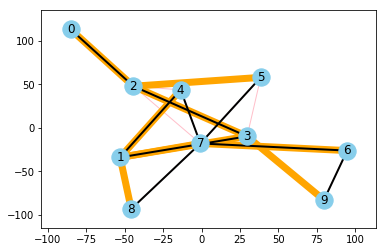

In [36]:
pos = nx.nx_pydot.pydot_layout(G, prog='neato')
nx.draw_networkx_edges(G, pos=pos, width=1, edge_color='pink')
nx.draw_networkx_edges(H, pos=pos, width=7, edge_color='orange')
nx.draw_networkx_edges(T, pos=pos, width=2, edge_color='black')
nx.draw_networkx(G, pos=pos, width=0, with_labels=True, node_color='skyblue')

## Wide-first spanning tree

Свойство: расстояние между вершиными такого дерева и корнем совпадает с их расстоянием в исходном графе.

In [109]:
def wide_spanning_tree(G, root=0, as_list=False):
    adj = {v: list(G.adj[v]) for v in G.adj}
    queue = deque()
    verts = set()
    edges = list()
    verts.add(root)
    queue.appendleft(root)
    while queue:
        v = queue.pop()
        for w in adj[v]:
            if w in verts:
                continue
            verts.add(w)
            edges.append((v,w))
            queue.appendleft(w)
    if as_list:
        return edges
    return nx.from_edgelist(edges)

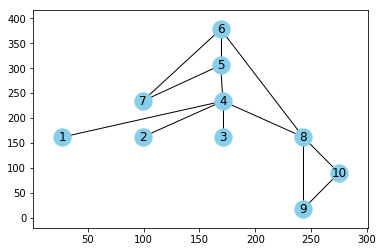

In [115]:
G = nx.from_edgelist([(6,5),(6,7),(6,8),
                      (8,9),(8,10),
                      (5,4),
                      (4,1),(4,2),(4,3),
                      (5,7),(4,8),(9,10)])
pos = nx.nx_pydot.pydot_layout(G.to_directed(), prog='dot')
nx.draw_networkx(G, pos=pos, node_color='skyblue')

In [116]:
wide_spanning_tree(G, root=6, as_list=True)

[(6, 5), (6, 7), (6, 8), (5, 4), (8, 9), (8, 10), (4, 1), (4, 2), (4, 3)]

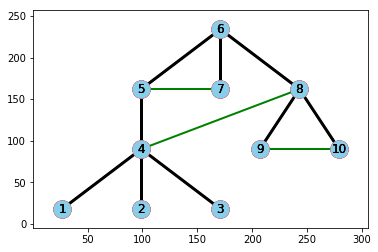

In [123]:
T = wide_spanning_tree(G, root=6)
pos = nx.nx_pydot.pydot_layout(T.to_directed(), prog='dot')
nx.draw_networkx(G, pos=pos, width=2, edge_color='green')
nx.draw_networkx(T, pos=pos, width=3, edge_color='black')
nx.draw_networkx(G, pos=pos, width=0, node_color='skyblue')

In [124]:
G = make_random_graph(10, connected=True, cyclic=True)
T = wide_spanning_tree(G)
pos = nx.nx_pydot.pydot_layout(T.to_directed(), prog='dot')
is_spanning_tree_of(T, G)

True

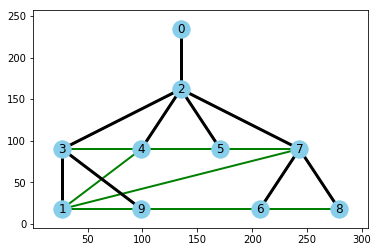

In [127]:
nx.draw_networkx_edges(G, pos=pos, width=2, edge_color='green')
nx.draw_networkx_edges(T, pos=pos, width=3, edge_color='black')
nx.draw_networkx(G, pos=pos, width=0, node_color='skyblue')

In [160]:
# test on many random samples
random.seed(1234)
num_test = 1000
max_size = 100
for i in range(num_test):
    RG = make_random_graph(randint(3, max_size), connected=True, cyclic=True)
    ST = wide_spanning_tree(RG)
    assert_is_spanning_tree_of(ST, RG)

## Расстояния между корнем и вершинами графа

In [134]:
def depth_from_root(G, root=0):
    nv = len(G.nodes)
    adj = [list(G.adj[v]) for v in G.adj]
    depth = [0] * nv
    queue = deque()
    verts = set()
    verts.add(root)
    queue.appendleft(root)
    while queue:
        v = queue.pop()
        for w in adj[v]:
            if w in verts:
                continue
            depth[w] = depth[v] + 1
            verts.add(w)
            queue.appendleft(w)
    return depth

In [156]:
G = make_random_graph(10, connected=True, cyclic=True)

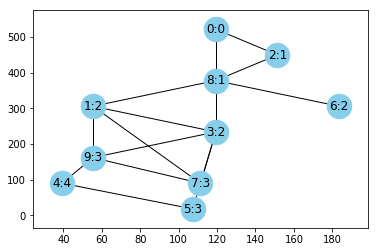

In [157]:
depth = depth_from_root(G)
mapping = {v: '%d:%d' % (v, depth[v]) for v in G.nodes }
H = nx.relabel_nodes(G, mapping)
pos = nx.nx_pydot.pydot_layout(H.to_directed(), prog='dot')
nx.draw_networkx(H, pos=pos, node_size=600, node_color='skyblue')

In [164]:
# test on many random samples
#random.seed(1234)
num_test = 1000
max_size = 100
for i in range(num_test):
    G = make_random_graph(randint(3, max_size), connected=True, cyclic=True)
    depth = depth_from_root(G)
    for v in G.nodes:
        assert depth[v] == nx.shortest_path_length(G, source=0, target=v)

### Test via simulated `sys.stdin`

In [176]:
stdin = '6 7\n0 1\n1 2\n2 0\n3 2\n4 3\n4 2\n5 4\n'
lineno = 0
def my_input():
    global lineno
    line = stdin.splitlines()[lineno]
    lineno += 1
    return line.strip()

from queue import deque

nv, ne = map(int, my_input().split())
adj = [[] for _ in range(nv)]
for _ in range(ne):
    v, w = map(int, my_input().split())
    adj[v].append(w)
    adj[w].append(v)

depth = [0] * nv
queue = deque([0])
verts = set([0])

while queue:
    v = queue.pop()
    for w in adj[v]:
        if w in verts:
            continue
        depth[w] = depth[v] + 1
        verts.add(w)
        queue.appendleft(w)

print(' '.join(map(str, depth)))

# expect: 0 1 1 2 2 3

0 1 1 2 2 3
